# Test 8: 60 MB/sec

## producer config

~~~~
limit_bytes_per_seconds=$(( 60 * 1024 * 1024 ))
-Dnum.producers=8 \
-Dproducer.threads=16 \
-Dmin.msg.size=175 \
-Dmax.msg.size=225 \

[kafka.config] {security.protocol=SASL_PLAINTEXT, receive.buffer.bytes=2097152, request.timeout.ms=6000, bootstrap.servers=host1.com:9092,host2.com:9092,host3.com:9092, value.serializer=org.apache.kafka.common.serialization.ByteArraySerializer, send.buffer.bytes=2097152, buffer.memory=536870912, retries=0, key.serializer=org.apache.kafka.common.serialization.IntegerSerializer, client.id=testproducer-001, linger.ms=200, sasl.mechanism=PLAIN, max.in.flight.requests.per.connection=16, batch.size=131072, max.block.ms=20000, acks=1}

~~~~

## consumer config
~~~~
-Dconsumer.threads=32

[kafka.config] {security.protocol=SASL_PLAINTEXT, receive.buffer.bytes=1048576, partition.assignment.strategy=org.apache.kafka.clients.consumer.RoundRobinAssignor, value.deserializer=org.apache.kafka.common.serialization.ByteArrayDeserializer, group.id=testconsumer, bootstrap.servers=host1.com:9092,host2.com:9092,host3.com:9092, send.buffer.bytes=1048576, max.partition.fetch.bytes=5242880, fetch.max.wait.ms=5000, client.id=testconsumer-001, key.deserializer=org.apache.kafka.common.serialization.IntegerDeserializer, sasl.mechanism=PLAIN, fetch.min.bytes=16384}
~~~~

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os, os.path
import numpy as np

In [2]:
plt.xkcd(scale=1, length=100, randomness=1)

In [3]:
DATA_DIR='data'

In [4]:
def load_data(csvfile, datadir):
    d = pd.read_csv(os.path.join(datadir, csvfile))
    d['datetime'] = pd.to_datetime(d.date + " " + d.time.str.slice(0,5), 
                                   format="%Y-%m-%d %H:%M") # upto minute only
    d.set_index('datetime', inplace=True)
    return d

def fix_ax(ax):
    ax.set_xlabel('')
    ax.axes.grid(linewidth=0.5)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    return ax

def test_duration_in_hours(t0, t1):
    #print "{} start({}) end({}) {} hours".format(tag, t0, t1, int((t1 - t0).total_seconds()/60/60))
    return int((t1 - t0).total_seconds()/60/60)

In [5]:
data_dir = os.path.join(DATA_DIR, '8')
#data_dir

In [6]:
consumer = load_data('consumer.csv', data_dir)
#consumer.head()

In [7]:
producer = load_data('producer.csv', data_dir)
#producer.head()

## Test Duration

In [8]:
limit=60 # MB
interval = 5  # minutes
freq = '%dT' % interval

delta = pd.Timedelta(4, 'h')
#delta = pd.Timedelta(0, 'h')

_start = consumer.index.min() + pd.Timedelta(22, 'h')
_end   = _start + pd.Timedelta(14, 'h')
consumer2 = consumer[np.logical_and(consumer.index >= _start, consumer.index <= _end)]


_start = producer.index.min() + pd.Timedelta(22, 'h')
_end   = _start + pd.Timedelta(14, 'h')
producer2 = producer[np.logical_and(producer.index >= _start, producer.index <= _end)]

# 
start    = _start
end      = _end
duration = int((end - start).total_seconds()/60/60)

metdata = pd.DataFrame.from_records(
    zip("start end duration limit interval".split(), (start, end, duration, limit, interval)),
    columns=('name','value'))

metdata.to_csv(os.path.join(data_dir,'metadata.txt'), index=False)

metdata

,name,value
0,start,2018-08-02 07:28:00
1,end,2018-08-02 21:28:00
2,duration,14
3,limit,60
4,interval,5


## Throughput

,count,mean,std,min,25%,50%,75%,max
consumer,167.0,264476.41,1059.59,257234.0,264459.0,264732.0,264978.5,265370.0
producer,167.0,264493.02,1058.68,257234.0,264468.0,264732.0,264984.0,265426.0


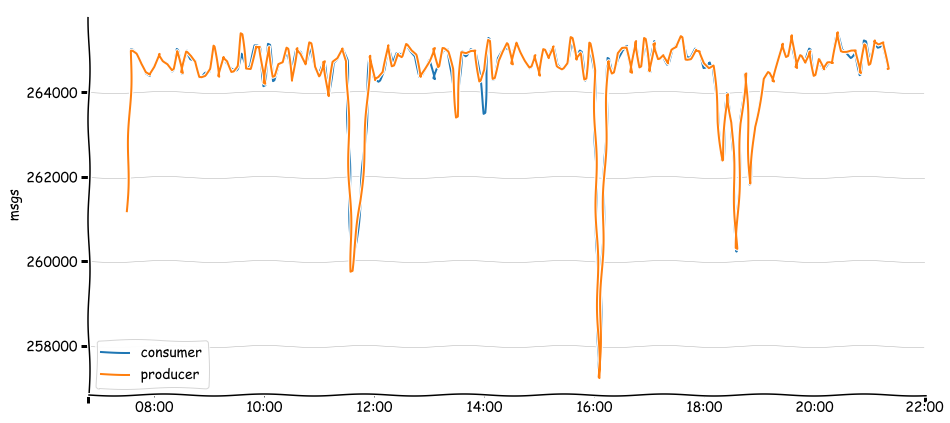

In [9]:
keys = ['consumer','producer']
df = pd.concat([consumer2[['msgs']], producer2[['msgs']]],
               keys=keys,
               axis=1
               )

df2 = df.groupby(pd.Grouper(freq=freq))
df2 = df2.sum()
df2 = df2/(interval*60) # per seconds
df2 = df2.round(2).astype(int)
df2 = df2[1:-1]
df2.columns = df2.columns.droplevel(1)
ax = df2.plot(subplots=False, figsize=(15,7))
fix_ax(ax)
ax.set_ylabel("msgs")
plt.savefig(os.path.join(data_dir, 'img', 'throughput-msgs.svg'))
df3 = df2.describe().T.round(2)
df3.to_csv(os.path.join(data_dir, 'throughput-msgs.txt'), index_label=['type'])
df3

,count,mean,std,min,25%,50%,75%,max
consumer,167.0,52.34,0.21,50.9,52.33,52.39,52.44,52.51
producer,167.0,52.34,0.21,50.9,52.33,52.38,52.44,52.52


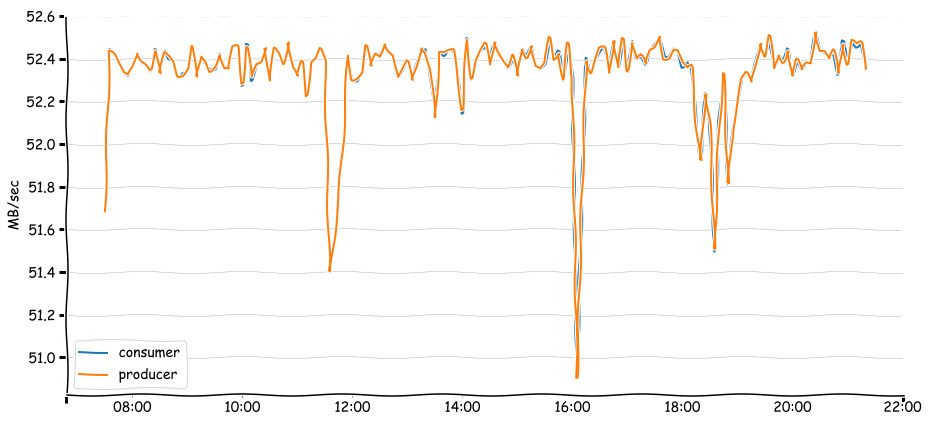

In [10]:
keys=['consumer','producer']
df = pd.concat([consumer2[['bytes']], producer2[['bytes']]],
               keys=keys,
               axis=1)
df2 = df.groupby(pd.Grouper(freq=freq)).sum()
df2 = df2[1:-1]/1024/1024/(interval*60)
df2.columns = df2.columns.droplevel(1)

ax = df2.plot(figsize=(15,7), subplots=False, legend=True)

fix_ax(ax)
ax.set_ylabel("MB/sec")
plt.savefig(os.path.join(data_dir, 'img', 'throughput.svg'))

df3 = df2.describe().T.round(2)
df3.to_csv(os.path.join(data_dir, 'throughput.txt'), index_label=['type'])
df3

## Latency

In [11]:
"{1}{0}".format(*"a,b,c".split(","))

'ba'

count     mean     std    min     25%     50%     75%  \
type     percentile                                                          
consumer p95         167.0   741.37   46.62  689.2   722.7   734.0   745.7   
         p99         167.0  1094.18  199.67  953.2  1025.9  1045.2  1074.6   
producer p95         167.0   303.36    8.56  288.2   297.1   302.2   308.5   
         p99         167.0   467.84  117.71  412.6   440.7   447.2   454.4   

                        max  
type     percentile          
consumer p95         1214.2  
         p99         2357.8  
producer p95          345.0  
         p99         1388.6

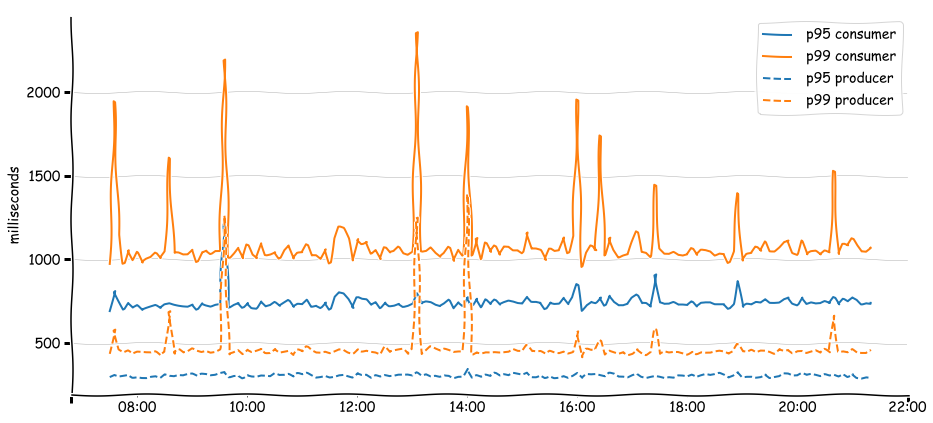

In [12]:
def lat_histo_p(d):
    d = d[d.columns[d.columns.str.startswith('lat_histo_p')]]
    d.columns = d.columns.str.replace('lat_histo_','')
    return d[1:-1]

df = pd.concat([lat_histo_p(consumer2), lat_histo_p(producer2)],
               keys=['consumer','producer'],
               names=['type'],
               axis=1
              )

df2 = df.loc[:, (slice(None), ('p95','p99'))]
df2 = df2.groupby(pd.Grouper(freq=freq)).mean().round(2)
df2 = df2[1:-1]

ax = df2.plot(figsize=(15,7), 
              subplots=False, 
              sharex=True, 
              sharey=True,
              style=['-','-','--','--'],
              color=['#1f77b4', '#ff7f0e']
             )
fix_ax(ax)
ax.legend().set_title('')
ax.set_ylabel('milliseconds')

handles, labels = ax.get_legend_handles_labels()
labels = map(lambda s: "{1} {0}".format(*s[1:-1].split(",")), labels)
ax.legend(handles, labels)

plt.savefig(os.path.join(data_dir, 'img', 'latency.svg'))

df3 = df2.describe().round(2).T
df3.index.names = ['type','percentile']
df3.to_csv(os.path.join(data_dir, 'latency.txt'))
df3

2 days 06:08:00
start=2018-08-01 09:28:00 end=2018-08-03 15:36:00
ploting start=2018-08-01 09:28:00 end=2018-08-03 15:36:00 interval=2 days 06:08:00


Text(0.5,1,'end-to-end latency\nstart=08/01 09:28 | end=08/03 15:36 | interval=54.13 hrs')

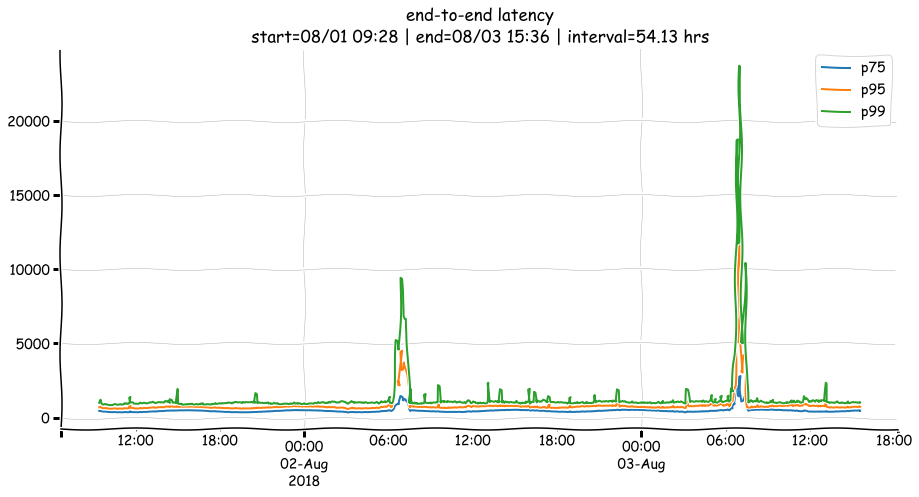

In [13]:
print consumer.index.max() - consumer.index.min()
#start = consumer.index.max() - pd.Timedelta(10, unit='m') # 'ns', 'us', 'ms', 's', 'm', 'h', 'D'
start = consumer.index.min() + pd.Timedelta(0, unit='m')
end   = consumer.index.max() - pd.Timedelta(0, unit='m')
print "start={} end={}".format(start, end)
consumer2 = consumer[np.logical_and(consumer.index >= start, consumer.index <= end)]
print "ploting start={} end={} interval={}".format(consumer2.index.min(), consumer2.index.max(),
                                   consumer2.index.max() - consumer2.index.min())
ax = lat_histo_p(consumer2)[['p75', 'p95','p99']].groupby(pd.Grouper(freq='5T')).mean().plot(figsize=(15,7))
fix_ax(ax)
plt.savefig(os.path.join(data_dir, 'img', 'latency-zoom.svg'))
ax.set_title("end-to-end latency\nstart={} | end={} | interval={} hrs".format(
    consumer2.index.min().strftime("%m/%d %H:%M"), 
    consumer2.index.max().strftime("%m/%d %H:%M"), 
    round((consumer2.index.max() - consumer2.index.min()).total_seconds()/60/60,2)
))

## Success

,msgs,success,error
datetime,,,
2018-08-02 04:00:00,504657238,504657229,0
2018-08-02 08:00:00,3807723438,3807563757,159590
2018-08-02 12:00:00,3812630968,3812112641,518245
2018-08-02 16:00:00,3804520027,3804407515,112376
2018-08-02 20:00:00,1414585044,1414521791,63196


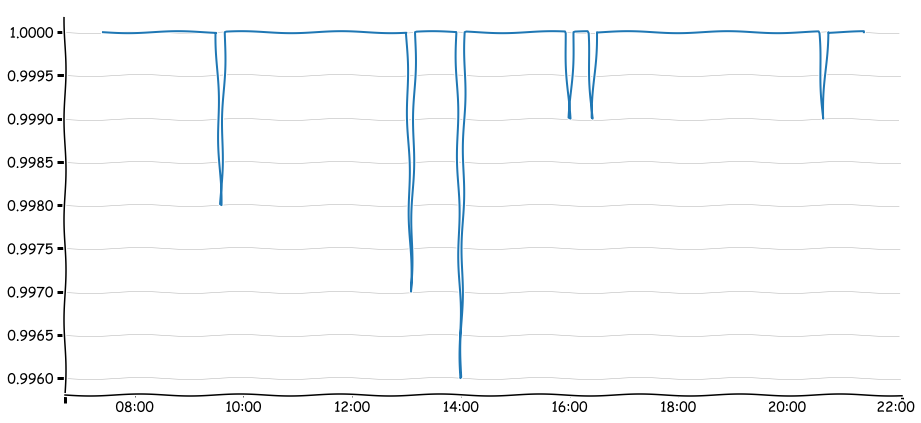

In [14]:
df = pd.DataFrame({
    'success': producer2.apply(lambda row: row.msgs if row.success > row.msgs else row.success, axis=1),
    'msgs'   : producer2.msgs, 
    'error'  : producer2.error,
    }, 
    index=producer2.index)
df['success_ratio']=df.success/df.msgs

df2 = df['success_ratio'].groupby(pd.Grouper(freq=freq)).mean().round(3)
axes = df2.plot(figsize=(15,7), legend=False)
axes = map(fix_ax, [axes])
plt.savefig(os.path.join(data_dir, 'img', 'success.svg'))

df3 = df[['msgs','success','error']].groupby(pd.Grouper(freq='4H')).sum()
df3.to_csv(os.path.join(data_dir, 'success.txt'))
df3